In [ ]:
!pip install torchtext==0.18.0

In [ ]:
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
import torch
import pandas as pd
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import random
import time
import torch.nn.functional as F

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [ ]:
RANDOM_SEED=42
torch.manual_seed(RANDOM_SEED)

NUM_EPOCHS = 15
BATCH_SIZE = 128
LEARNING_RATE = 0.005
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2
VOCAB_SIZE=20000

torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [ ]:
tokenizer=get_tokenizer('spacy',language='en_core_web_sm')

In [ ]:
def yeild_tokens(data_iter):
    for _,text in data_iter:
        yield tokenizer(text)

In [ ]:
class IMDBCSVDataset(Dataset):
    def __init__(self,csv):
        self.data=pd.read_csv(csv)
        self.data['sentiment']=self.data['sentiment'].map({'positive':1,'negative':0})

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        label=self.data.iloc[idx]['sentiment']
        text=self.data.iloc[idx]['review']
        return label,text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset=IMDBCSVDataset('/content/drive/My Drive/IMDB_sentiment_analysis/IMDB Dataset.csv')
train_dataset,test_dataset=torch.utils.data.random_split(dataset,[0.8,0.2])
train_dataset,val_dataset=torch.utils.data.random_split(train_dataset,[0.85,0.15])

print(f'Length of train dataset: {len(train_dataset)}')
print(f'Length of val dataset: {len(val_dataset)}')
print(f'Length of test dataset: {len(test_dataset)}')

Length of train dataset: 34000
Length of val dataset: 6000
Length of test dataset: 10000


In [ ]:
vocab=build_vocab_from_iterator(yeild_tokens(train_dataset),max_tokens=VOCAB_SIZE,specials=['<unk>','<pad>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
def text_pipeline(x):
    tokens=tokenizer(x)
    indexed_token=[vocab[token] for token in tokens]
    return torch.tensor(indexed_token,dtype=torch.long)


In [ ]:
def collate_fn(batch):
    labels,texts=[],[]
    for label,text in batch:
        labels.append(label)
        processed_text=text_pipeline(text)
        texts.append(processed_text)
    labels=torch.tensor(labels,dtype=torch.long)
    texts=pad_sequence(texts,batch_first=True,padding_value=vocab['<pad>'])
    return labels,texts

In [ ]:
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)

In [ ]:
class luongAttention(nn.Module):
    def __init__(self,hidden_dim):
        super(luongAttention,self).__init__()
        self.attention=nn.Linear(hidden_dim,hidden_dim)
        self.score = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self,encoder_outputs):
        energy=torch.tanh(self.attention(encoder_outputs))
        scores=self.score(energy).squeeze(-1)
        attn_weights=F.softmax(scores,dim=1)

        context=torch.bmm(attn_weights.unsqueeze(1),encoder_outputs).squeeze(1)
        return context,attn_weights

class BiLSTMAttentionModel(nn.Module):
    def __init__(self,input_dim,embedding_dim,hidden_dim,output_dim,pad_idx):
        super(BiLSTMAttentionModel,self).__init__()
        self.embedding=nn.Embedding(input_dim,embedding_dim,padding_idx=pad_idx)
        self.lstm=nn.LSTM(embedding_dim,hidden_dim,bidirectional=True,batch_first=True)
        self.attention=luongAttention(hidden_dim*2)
        self.fc=nn.Linear(hidden_dim*2,output_dim)

    def forward(self,text):
        embedded=self.embedding(text)
        output,(hidden,cell)=self.lstm(embedded)
        attn_output,attn_weights=self.attention(output)
        out=self.fc(attn_output)
        return out, attn_weights

In [ ]:
def compute_accuracy(model,data_loader):
    model.eval()
    correct_predictions=0
    total_predictions=0
    with torch.no_grad():
        for labels,texts in data_loader:
            labels=labels.to(DEVICE)
            texts=texts.to(DEVICE)
            outputs,_=model(texts)
            _,predicted=torch.max(outputs,1)
            correct_predictions+=(predicted==labels).sum().item()
            total_predictions+=labels.size(0)
    accuracy=correct_predictions/total_predictions
    return accuracy

In [ ]:
torch.manual_seed(RANDOM_SEED)
model=BiLSTMAttentionModel(input_dim=len(vocab),embedding_dim=EMBEDDING_DIM,hidden_dim=HIDDEN_DIM,output_dim=NUM_CLASSES,pad_idx=vocab['<pad>'])
model=model.to(DEVICE)
optimizer=torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion=nn.CrossEntropyLoss()
criterion=criterion.to(DEVICE)
train_accs=[]
val_accs=[]

In [ ]:
start=time.time()
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss=0
    for labels,texts in train_loader:
        labels=labels.to(DEVICE)
        texts=texts.to(DEVICE)
        optimizer.zero_grad()
        outputs,_=model(texts)
        loss=criterion(outputs,labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss+=loss.item()
    train_acc=compute_accuracy(model,train_loader)
    val_acc=compute_accuracy(model,val_loader)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}: \n- Loss: {epoch_loss/len(train_loader):.4f} \n- Train Acc: {train_acc*100:.2f}% \n-Val Acc: {val_acc*100:.2f}% \n- Time: {((time.time()-start)/60.00):.2f} minutes')


Epoch 1/15: 
- Loss: 0.3750 
- Train Acc: 93.08% 
-Val Acc: 89.10% 
- Time: 4.38 minutes
Epoch 2/15: 
- Loss: 0.1737 
- Train Acc: 98.04% 
-Val Acc: 91.00% 
- Time: 8.83 minutes
Epoch 3/15: 
- Loss: 0.0762 
- Train Acc: 99.11% 
-Val Acc: 89.87% 
- Time: 13.21 minutes
Epoch 4/15: 
- Loss: 0.0296 
- Train Acc: 99.63% 
-Val Acc: 89.93% 
- Time: 17.56 minutes
Epoch 5/15: 
- Loss: 0.0157 
- Train Acc: 99.83% 
-Val Acc: 89.88% 
- Time: 21.90 minutes
Epoch 6/15: 
- Loss: 0.0104 
- Train Acc: 99.87% 
-Val Acc: 90.18% 
- Time: 26.27 minutes
Epoch 7/15: 
- Loss: 0.0110 
- Train Acc: 99.84% 
-Val Acc: 89.78% 
- Time: 30.62 minutes
Epoch 8/15: 
- Loss: 0.0085 
- Train Acc: 99.88% 
-Val Acc: 90.47% 
- Time: 34.97 minutes
Epoch 9/15: 
- Loss: 0.0067 
- Train Acc: 99.94% 
-Val Acc: 90.22% 
- Time: 39.34 minutes
Epoch 10/15: 
- Loss: 0.0054 
- Train Acc: 99.91% 
-Val Acc: 89.73% 
- Time: 43.69 minutes
Epoch 11/15: 
- Loss: 0.0090 
- Train Acc: 99.78% 
-Val Acc: 89.75% 
- Time: 48.04 minutes
Epoch 12/1

Text(0.5, 1.0, 'Training and Validation acc over Epochs')

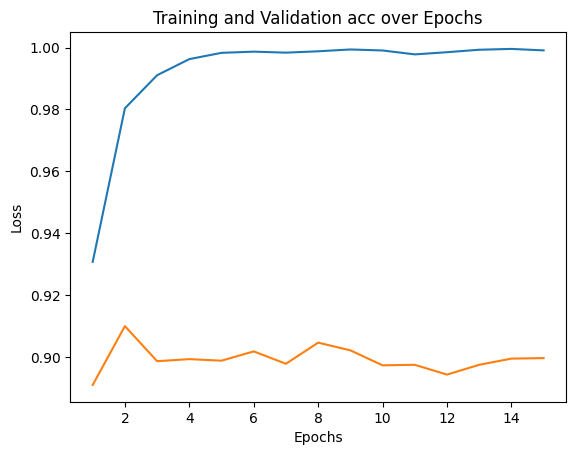

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, NUM_EPOCHS + 1), train_accs, label='Training acc')
plt.plot(range(1, NUM_EPOCHS + 1), val_accs, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation acc over Epochs')